# Learning Z/nZ x Z/nZ group actions
This notebook is adapted from the `modular arithmetic` notebook, replacing `Z/nZ` group action with `Z/nZ x Z/nZ` group action 

In [1]:
import numpy as np
import random
import torch
import os
import torch.nn as nn
import torch.optim as optim
import shutil
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MaxNLocator
import setcwd
setcwd.main()

import importlib
import pickle

import group_agf.binary_action_learning.models as models
import group_agf.binary_action_learning.datasets as datasets
import group_agf.binary_action_learning.power as power
import group_agf.binary_action_learning.train as train
import group_agf.binary_action_learning.plot as plot


Git root path:  /home/adele/group-agf

Working directory:  /home/adele/group-agf/gagf
Directory added to path:  /home/adele/group-agf
Directory added to path:  /home/adele/group-agf/gagf/group_learning
Directory added to path:  /home/adele/group-agf/gagf/group_learning/saved_datasets
Directory added to path:  /home/adele/group-agf/gagf/notebooks
Directory added to path:  /home/adele/group-agf/gagf/notebooks/saved_models


# Define Dataset and Visualize

In [2]:
from group_agf.binary_action_learning.default_config import verbose_interval


p = 5
mnist_digit = 4
dataset_fraction = 0.2
template_type = 'mnist'
seed = 47
batch_size = 128
hidden_size = 128
lr = 0.001
mom = 0.9
init_scale = 1e-2
epochs = 1000
verbose_interval = 100

model_save_path = (
    f"/tmp/adele/model_"
    f"p{p}_"
    f"digit{mnist_digit}_"
    f"frac{dataset_fraction}_"
    f"type{template_type}_"
    f"seed{seed}.pkl"
)

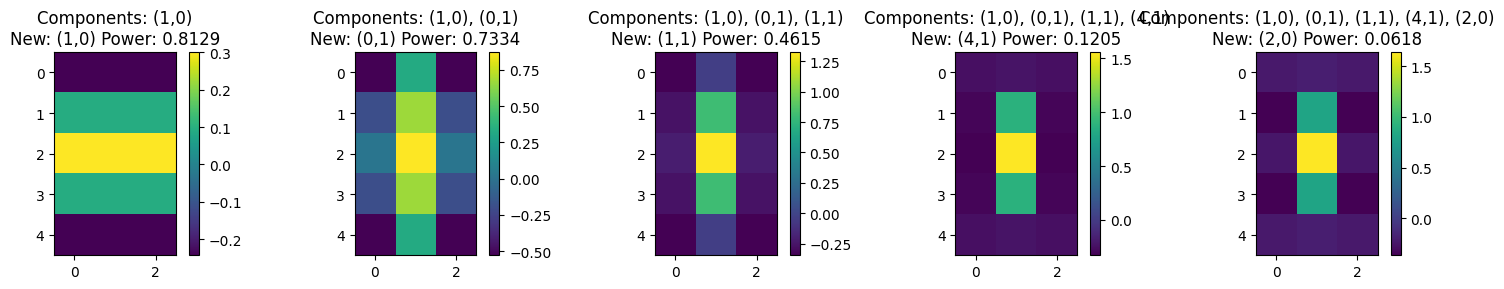

In [ ]:
template = datasets.choose_template(p, template_type, mnist_digit)
group = 'cnxcn'

top_frequency_plot = plot.plot_top_template_components(group, template, p)

In [4]:
X, Y, translations = datasets.load_modular_addition_dataset_2d(p, template, fraction=dataset_fraction, random_state=seed, template_type=template_type)

X, Y, device = datasets.move_dataset_to_device_and_flatten(X, Y, p, device=None)

dataset = TensorDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

X_tensor shape: torch.Size([125, 50]), Y_tensor shape: torch.Size([125, 25])
GPU is available. Using CUDA.


# Define Model and Train

In [5]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using GPU

model = models.TwoLayerNet(p=p, hidden_size=hidden_size, nonlinearity='square', init_scale=init_scale, output_scale=1e0)
model = model.to(device)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(mom, 0.999))

loss_history, accuracy_history, param_history = train.train(
    model,
    dataloader,
    loss,
    optimizer,
    epochs=epochs,
    verbose_interval=verbose_interval,
    model_save_path=model_save_path
)

Epoch 100/1000, Loss: 0.0208, Accuracy: 95.20%
Epoch 200/1000, Loss: 0.0079, Accuracy: 94.40%
Epoch 300/1000, Loss: 0.0034, Accuracy: 93.60%
Epoch 400/1000, Loss: 0.0013, Accuracy: 96.00%
Epoch 500/1000, Loss: 0.0005, Accuracy: 96.00%
Epoch 600/1000, Loss: 0.0002, Accuracy: 100.00%
Epoch 700/1000, Loss: 0.0001, Accuracy: 100.00%
Epoch 800/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 900/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 1000/1000, Loss: 0.0000, Accuracy: 100.00%
Training history saved to /tmp/adele/model_p5_digit4_frac0.2_typemnist_seed47.pkl. You can reload it later with pickle.load(open(/tmp/adele/model_p5_digit4_frac0.2_typemnist_seed47.pkl, 'rb')).


# Plot loss, power, and model output

[[7.88860905e-33 7.33358700e-01 7.05039577e-03]
 [8.12947267e-01 4.61487568e-01 3.90681279e-02]
 [6.18294264e-02 5.41821331e-02 2.70363545e-02]
 [0.00000000e+00 3.39143925e-02 2.07441338e-02]
 [0.00000000e+00 1.20469910e-01 4.20715659e-02]]
Plotting alpha value 0: 0.09656639897639972
Plotting alpha value 1: 0.06404850829810516
Plotting alpha value 2: 0.03471416030083618
Plotting alpha value 3: 0.01625465758805998
Plotting alpha value 4: 0.011435861199303197
Plotting alpha value 5: 0.00896268414414812
Plotting alpha value 6: 0.006795398818855064
Plotting alpha value 7: 0.005112536181609164
Plotting alpha value 8: 0.0035498110647676803
Plotting alpha value 9: 0.0021932353627725897
Plotting alpha value 10: 0.0011117811835692204
Plotting alpha value 11: 0.000282015830801134


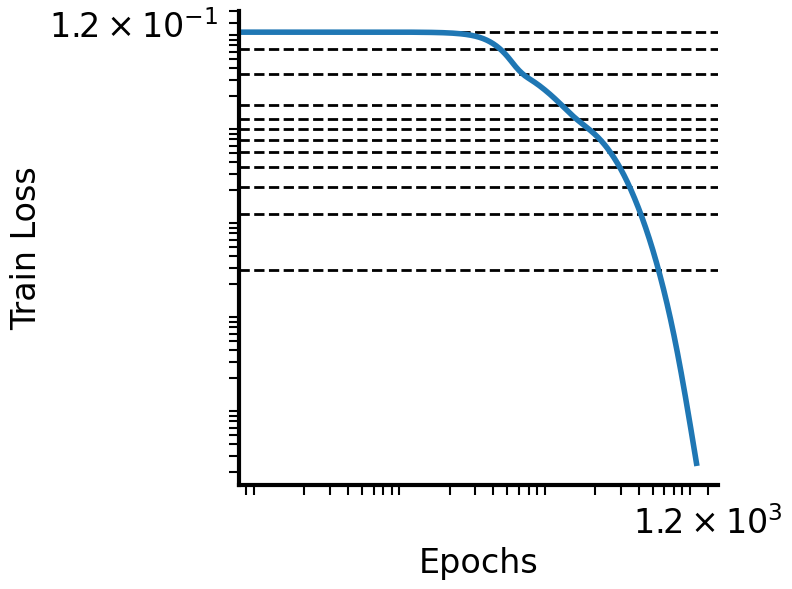

In [6]:
loss_plot = plot.plot_loss_curve(loss_history, template)

top_5_power_idx: [ 3  1  4 13  6]
Powers over time shape: (424, 15)


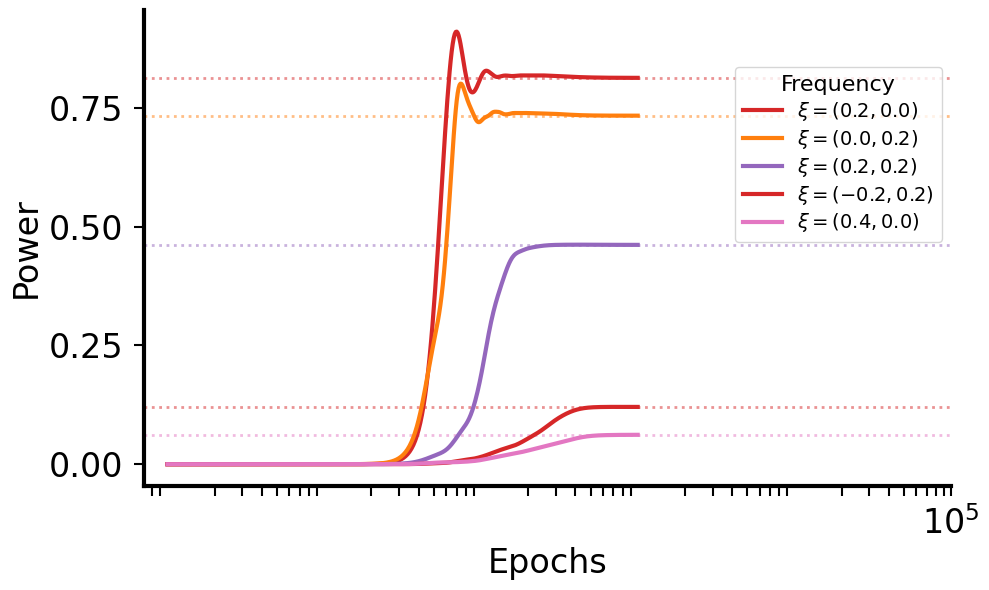

In [7]:
template_2d = template.reshape((p, p))
power_over_training_plot = plot.plot_training_power_over_time(template_2d, model, device, param_history, X, p, save_path=None, show=False)    

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


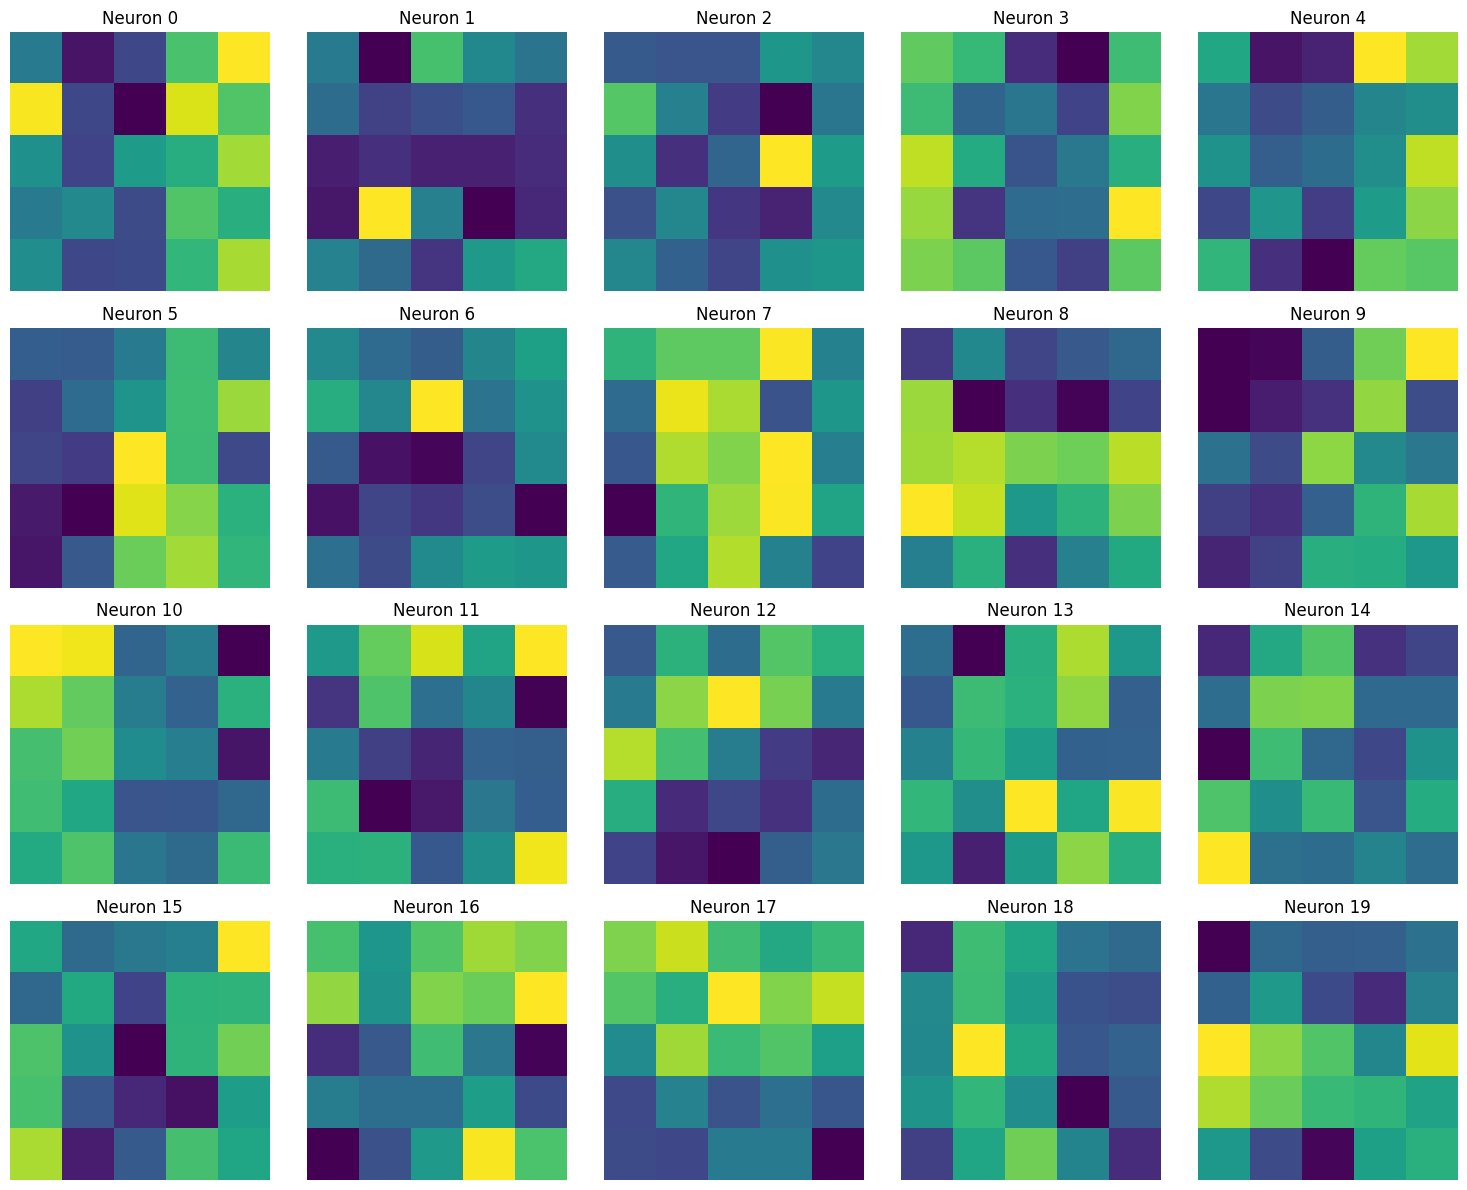

In [ ]:
neuron_indices = list(range(20))
group= 'cnxcn'
print(neuron_indices)
neuron_weights_plot = plot.plot_neuron_weights(group, model, p, neuron_indices=neuron_indices, show=True)

x shape: torch.Size([1, 50]), y shape: torch.Size([1, 25])


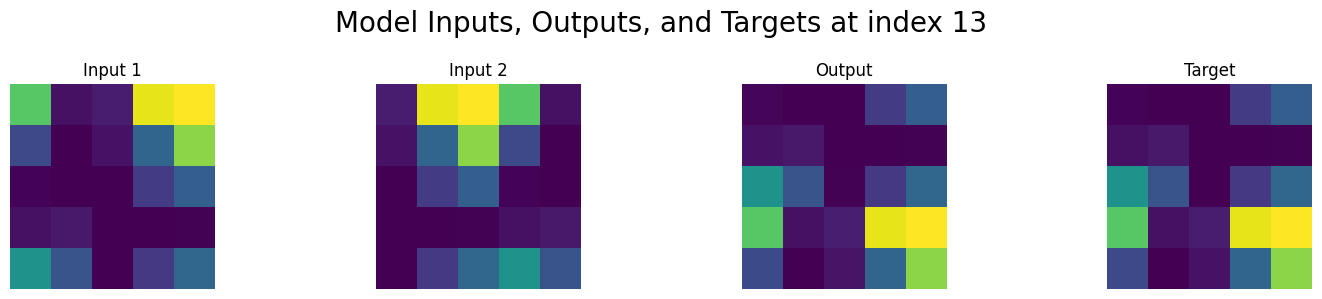

In [ ]:
idx = 13
plot.plot_model_outputs(p, model, X, Y, idx)